import useful package

In [1]:
import torch
import matplotlib.pyplot as plt
import yousef_model as model
import Naicheng.res.process_data.process_output as pro_out
import Naicheng.res.process_data.process_raw_data as pr
import Naicheng.res.process_data.dire_and_coor as dc
from Naicheng.res.process_data.dataset import tensor_dataset
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
import json

1. read raw data
2. calculate the n to n distance of input polymer

In [2]:
input_coorinate = pr.read_coordinate(16, '../../data/Coordinates.dat')
input_three_dirc = dc.coordinates_directions_three(input_coorinate)
n2n_input = np.zeros(np.shape(input_coorinate)[0])
for i in range(len(n2n_input)):
    n2n_input[i] = pro_out.n_n_distance(input_coorinate[i])
pro_out.statistics(n2n_input)

(6.499296237636025, 2.262412079054168, 5.118508415450203)

for input data we have the n to n distance:

mean value: 6.499296237636025

std: 2.262412079054168

mse: 5.118508415450203

In [3]:
def slice_directions(output):
    z_dim = np.shape(output)[0]
    direction_dim = np.shape(output)[1]
    assert direction_dim == 15, "the input dimension should be (x, 15)"
    test_dirc = np.zeros([z_dim,direction_dim,1])
    for i in range(z_dim):
        for j in range(direction_dim):
            test_dirc[i][j][0] = output[i][j]
    # round direction
    test_dirc = np.round(test_dirc * 2) / 2
    return test_dirc

In [4]:
# load model
def process_model(epoch, evaluate):
    name = f'models/yousef_gan_{epoch}.pth.tar'
    gen = model.GeneratorNet()
    check_point = torch.load(name)
    gen.load_state_dict(check_point['gen_state_dict'])
    # check the output
    output_list = []
    num_ite = 2000
    output_direction = np.zeros([num_ite * 8, 15, 1])
    for i in range(num_ite):
        # get output
        noise = model.noise(8)
        output = gen(noise).data.numpy()
        # get a list for histogram
        for j in range(8):
            for k in range(15):
                output_list.append(output[j][k])
        # slice the output to a (n ,15 ,1)
        output_direction[8 * i : 8 * (i+1)] = slice_directions(output)
    # plot the histogram of the output
    sns.histplot(data=output_list)
    plt.savefig(f'output with epoch{epoch}.png')
    plt.clf()
    # count target output
    count_0, count_1, count_2 = 0, 0, 0
    for i in output_list:
        if i <= 0.1: count_0 +=1
        elif 0.45 < i < 0.55: count_1 += 1
        elif i >= 0.9: count_2 += 1
    evaluate['count_0'] = count_0
    evaluate['count_0.5'] = count_1
    evaluate['count_1'] = count_2
    a, _ = pro_out.remove_duplicated(output_direction)
    without_duplicate = len(a)
    evaluate['unique'] = without_duplicate
    output_coor = dc.direction_coordinate_three(output_direction)
    # check output overlap with raw data
    overlap = pro_out.check_overlap(input_three_dirc, output_direction)
    folding, crossing, self_avoid = pro_out.count_fold_cross(output_coor)
    evaluate['overlap'] = overlap
    evaluate['crossing'] = crossing
    evaluate['self_avoid'] = self_avoid
    # get n to n distance
    n2n = np.zeros(num_ite * 8)
    for i in range(len(n2n)):
        n2n[i] = pro_out.n_n_distance(output_coor[i])
    # get statistics property of n to n distance
    out_mean, out_std, out_mse = pro_out.statistics(n2n)
    evaluate['mean'] = out_mean
    evaluate['std'] = out_std
    evaluate['mse'] = out_mse
    return evaluate

1. epoch
2. 0, 0.5, and 1 count
3. without duplication
4. cross, self avoid
5. overlap
6. mean, std, out_mse

In [5]:
# from tqdm.auto import tqdm
# total = {}
# for i in tqdm(range(0,30)):
#     a = process_model(100 * (i + 1), {})
#     total[f'epoch{100 * (i + 1)}'] = a

In [6]:
# with open('data.json', 'w') as fp:
#     json.dump(total, fp)

In [7]:
with open('data.json', 'r') as fp:
    data = json.load(fp)

In [8]:
count_0 = []
count_1 = []
count_2 = []
unique = []
cross = []
self_avoid = []
overlap = []
mean = []
std = []
mse = []
for i in range(30):
    epoch = (i+1) * 100
    key_epoch = f'epoch{epoch}'
    count_0.append(data[key_epoch]['count_0'])
    count_1.append(data[key_epoch]['count_0.5'])
    count_2.append(data[key_epoch]['count_1'])
    unique.append(data[key_epoch]['unique'])
    cross.append(data[key_epoch]['crossing'])
    self_avoid.append(data[key_epoch]['self_avoid'])
    overlap.append(data[key_epoch]['overlap'])
    mean.append(data[key_epoch]['mean'])
    std.append(data[key_epoch]['std'])
    mse.append(data[key_epoch]['mse'])

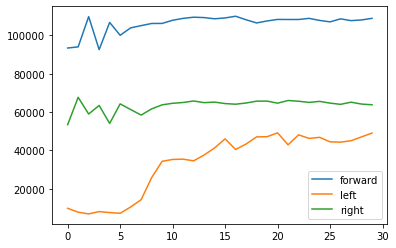

In [9]:
plt.plot(count_0, label='forward')
plt.plot(count_1, label='left')
plt.plot(count_2, label='right')
plt.legend(loc='best')
plt.show()

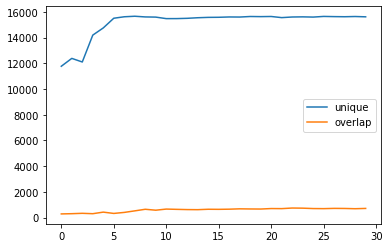

In [10]:
plt.plot(unique, label='unique')
plt.plot(overlap, label='overlap')
plt.legend(loc='best')
plt.show()

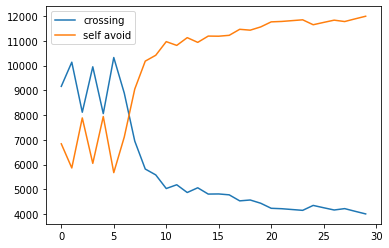

In [11]:
plt.plot(cross, label='crossing')
plt.plot(self_avoid, label='self avoid')
plt.legend(loc='best')
plt.show()

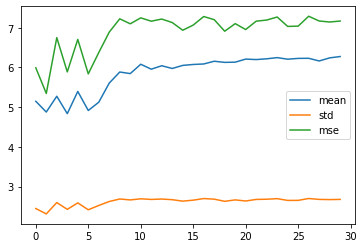

In [12]:
plt.plot(mean, label='mean')
plt.plot(std, label='std')
plt.plot(mse, label='mse')
plt.legend(loc='best')
plt.show()

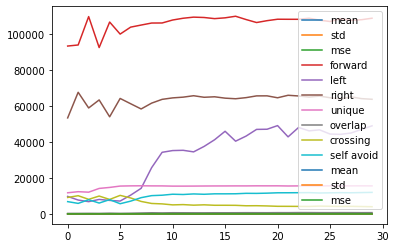

In [13]:
plt.plot(mean, label='mean')
plt.plot(std, label='std')
plt.plot(mse, label='mse')
plt.plot(count_0, label='forward')
plt.plot(count_1, label='left')
plt.plot(count_2, label='right')
plt.plot(unique, label='unique')
plt.plot(overlap, label='overlap')
plt.plot(cross, label='crossing')
plt.plot(self_avoid, label='self avoid')
plt.plot(mean, label='mean')
plt.plot(std, label='std')
plt.plot(mse, label='mse')
plt.legend(loc='best')
plt.show()